In [1]:
import os

In [2]:
import xarray as xr
import pandas as pd
import netCDF4 as nc
from pathlib import Path
from natsort import natsorted
import matplotlib.pyplot as plt
import gc
import os 
from os.path import exists
import dask_labextension
import numpy as np

In [3]:
import gsw, xwmt, xgcm
import cmocean.cm as cm

In [20]:
def ds_to_grid(ds):
    
    coords={
        'X': {k:v for (k,v) in {'center':'xh','outer':'xq'}.items()
              if v in ds},
        'Y': {k:v for (k,v) in {'center':'yh','outer':'yq'}.items()
              if v in ds},
    }
    if "rho2_l" in ds.dims:
        coords = {
            **coords,
            **{'Z': {'center': 'rho2_l', 'outer': 'rho2_i'}}
        }
    elif "zl" in ds.dims:
        coords = {
            **coords,
            **{'Z': {'center': 'zl', 'outer': 'zi'}}
        }
    elif "z_l" in ds.dims:
        coords = {
            **coords,
            **{'Z': {'center': 'z_l', 'outer': 'z_i'}}
        }
        
    if "areacello" in ds:
        metrics = {
            ('X','Y'): "areacello",
        }
    else:
        metrics = {}
    
    boundary = {"X":"periodic", "Y":"periodic", "Z":"extend"}
    
    return xgcm.Grid(
        ds,
        coords=coords,
        metrics=metrics,
        boundary=boundary, 
        autoparse_metadata=False
    )

In [5]:
xgcm.__version__, xwmt.__version__

('0.8.2.dev15+g7492277', '0.1.0')

In [6]:
def add_estimated_layer_interfaces(ds):
    return ds.assign_coords({"zi": xr.DataArray(
        np.concatenate([[0], 0.5*(ds.zl.values[1:]+ds.zl.values[0:-1]), [6000]]),
        dims=('zi',)
    )})

In [7]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='192GB',
    walltime='02:00:00',
    queue='scavenger',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=16)
from dask.distributed import Client
client = Client(cluster)

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p scavenger
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=179G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/bin/python -m distributed.cli.dask_worker tcp://172.16.3.103:40131 --nthreads 36 --memory-limit 178.81GiB --name dummy-name --nanny --death-timeout 60 --interface ib0



In [8]:
def add_estimated_layer_interfaces(ds):
    return ds.assign_coords({"zi": xr.DataArray(
        np.concatenate([[0], 0.5*(ds.zl.values[1:]+ds.zl.values[0:-1]), [6000]]),
        dims=('zi',)
    )})

In [131]:
def get_sigma2(ds, keep_vars = False): 
    ds['p'] = xr.apply_ufunc(
        gsw.p_from_z, ds.z, ds.lat, 0, 0, dask="parallelized"
    )


    ds['sa'] = xr.apply_ufunc(
        gsw.SA_from_SP,
        ds.so,
        ds.p,
        ds.lon,
        ds.lat,
        dask="parallelized",
    )
    ds['ct'] = xr.apply_ufunc(
        gsw.CT_from_t,
        ds.sa,
        ds.thetao,
        ds.p,
        dask="parallelized"
    )

    ds['sigma2'] = xr.apply_ufunc(
        gsw.sigma2,
        ds.sa,
        ds.ct,
        dask="parallelized"
    )
    if keep_vars: 
        return ds
    else: 
        return ds.drop_vars(["p", "sa", "ct"])

In [11]:
client

<Client: 'tcp://172.16.3.103:40131' processes=2 threads=72, memory=357.62 GiB>

In [12]:
def read_CM4X(fname): 
    return xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":-1, "longitude":-1, "time":-1, "depth":2},
        engine="zarr")

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

In [13]:
CM4Xp25_historical = read_CM4X("../../CM4Xp25_historical_transient_tracers.zarr")
CM4Xp25_ssp585 = read_CM4X("../../CM4Xp25_ssp585_transient_tracers.zarr")
CM4Xp25_piControl = read_CM4X("../../CM4Xp25_piControl_transient_tracers.zarr")

In [126]:
tmp_ds = CM4Xp25_historical.isel(year = slice(0, 3)).compute()             
tmp_ds["z"] = tmp_ds.z.transpose("year", "zl", "yh", "xh")
tmp_ds = add_estimated_layer_interfaces(tmp_ds)
grid = ds_to_grid(1 * tmp_ds)

In [ ]:
wm = xwmt.WaterMass(grid)
wm.get_density("sigma2");
grid = wm.grid # reassign grid since we have modified a copy within wm
ds = grid._ds # reassign ds since we have modified a copy within grid

In [132]:
ds2 = get_sigma2(1 * tmp_ds)

In [133]:
kwargs = {"xh": -165, "year": 2000}
σ2 = ds['sigma2'].sel(method="nearest", **kwargs).compute()
σ2_fast = ds2['sigma2'].sel(method="nearest", **kwargs).compute()

z = ds.z.sel(method="nearest", **kwargs).compute() # broadcast vertical coordinate to two-dimensional mesh
z2 = ds2.z.sel(method="nearest", **kwargs).compute() # broadcast vertical coordinate to two-dimensional mesh

z2.values[np.isnan(z2.values)] = 0.0

In [134]:
y.shape, z.shape, σ2.shape

((540, 75), (540, 75), (75, 540))

/tmp/ipykernel_3067/2066273022.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0].pcolormesh(y,z,σ2.transpose(), cmap=cm.dense, vmin=35, vmax=37.5)
/tmp/ipykernel_3067/2066273022.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[1].pcolormesh(y,z,σ2_fast.transpose(), cmap=cm.dense, vmin=35, vmax=37.5)
/tmp/ipykernel_3067/2066273022.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges t

<xarray.DataArray 'sigma2' ()>
array(0.00017506)
Coordinates:
    xh       float64 -165.0
    year     int64 1852
<xarray.DataArray 'z' ()>
array(70.09000559)
Coordinates:
    xh       float64 -165.0
    year     int64 1852


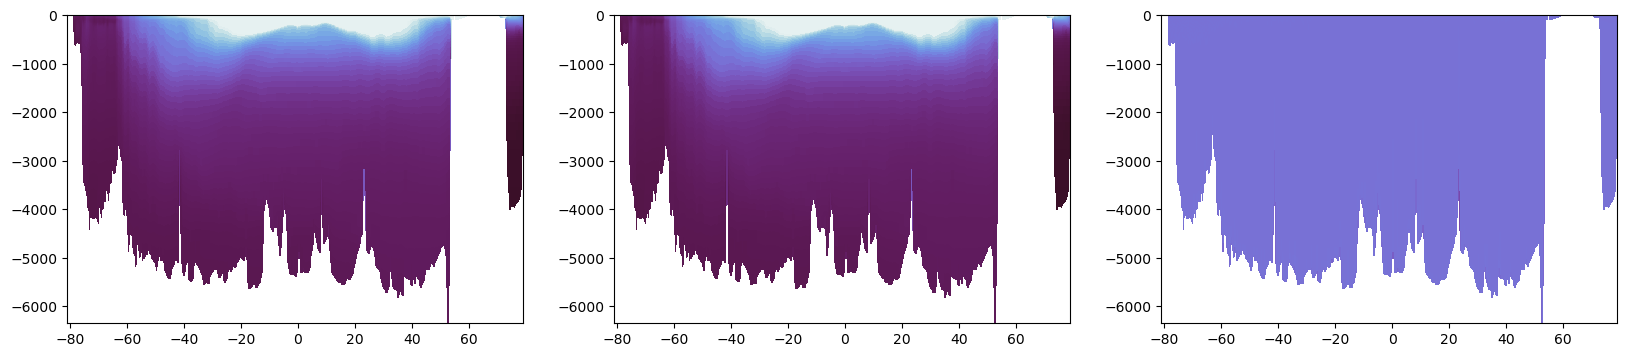

In [140]:
_, y = np.meshgrid(σ2.zl, σ2.geolat) # broadcast latitude

fig, ax = plt.subplots(1,3,figsize=(20, 4))
ax[0].pcolormesh(y,z,σ2.transpose(), cmap=cm.dense, vmin=35, vmax=37.5)
ax[1].pcolormesh(y,z,σ2_fast.transpose(), cmap=cm.dense, vmin=35, vmax=37.5)
ax[2].pcolormesh(y,z,(σ2 - σ2_fast).transpose(), cmap=cm.dense, vmin=-0.1, vmax=0.1)
print((σ2 - σ2_fast).mean())
print(np.sqrt(((z - z2)**2).mean()))

# fig.colorbar(label=r"potential density $\sigma_{2}$ [kg/m$^{3}$]", ax = ax[:])

# plt.xlabel("latitude [degrees]")
# plt.ylabel("elevation [m]")

In [37]:
ds = CM4Xp25_historical

kwargs = {"xh": -165, "year": 2000}
σ2 = ds['thetao'].sel(method="nearest", **kwargs).compute()
z = ds.z.sel(method="nearest", **kwargs).compute() # broadcast vertical coordinate to two-dimensional mesh
z.values[np.isnan(z.values)] = 10

/tmp/ipykernel_3067/351185529.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(y,z,σ2.transpose(), cmap=cm.thermal, vmin=-1, vmax=29)


Text(0, 0.5, 'elevation [m]')

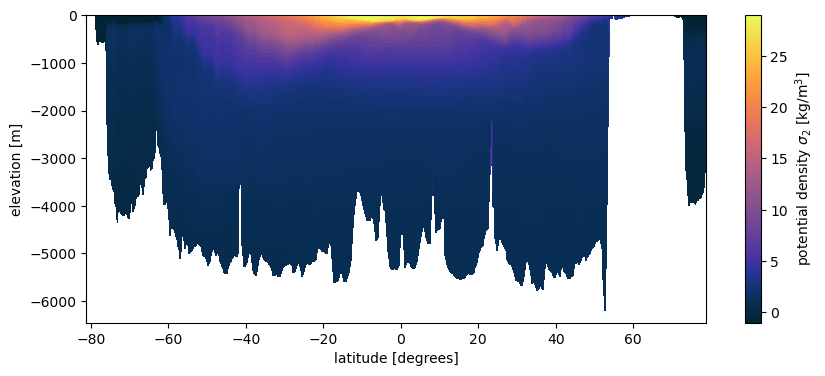

In [38]:
_, y = np.meshgrid(σ2.zl, σ2.geolat) # broadcast latitude

fig, ax = plt.subplots(1,1,figsize=(10, 4))
plt.pcolormesh(y,z,σ2.transpose(), cmap=cm.thermal, vmin=-1, vmax=29)
plt.colorbar(label=r"potential density $\sigma_{2}$ [kg/m$^{3}$]")
plt.contour(
    y,
    z,
    σ2.transpose(),
    levels=[35, 36.6, 37],
    colors="k"
);
plt.xlabel("latitude [degrees]")
plt.ylabel("elevation [m]")

In [39]:
point_historical = CM4Xp25_historical.cfc12.sel(yh = -60, xh = -180, method = "nearest").compute()
# point_PiControl = CM4Xp25_piControl.sel(yh = -70, xh = -180, method = "nearest").compute()
point_ssp585 = CM4Xp25_ssp585.cfc12.sel(yh = -60, xh = -180, method = "nearest").compute()

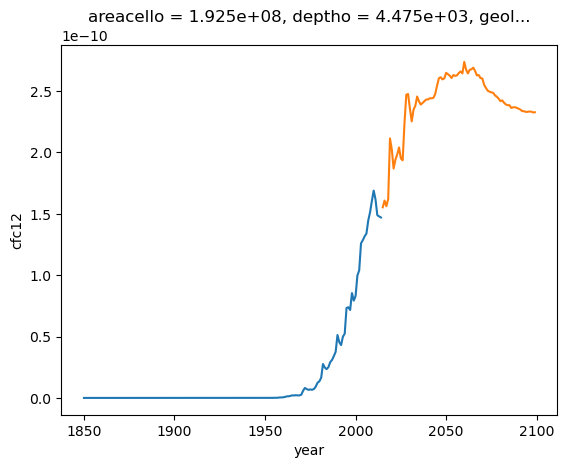

In [40]:
fig, ax = plt.subplots()
point_historical.isel(zl = 65).plot(ax = ax, label = "historical")
point_ssp585.isel(zl = 65).plot(ax = ax, label = "PiControl")

Warning: CFCs are probably given in mol / m3. To compare to obs, need to change units to picomol / kg. Can use m = \rho * V i.e. need to divide by the density of the grid cell. This is a approximately a scaling of 10^9. 

In [41]:
cfc12_2015_historical = compute_depth_average(CM4Xp25_historical, 3000, 4000).isel(year = -1).compute()
cfc12_2015_ssp585 = compute_depth_average(CM4Xp25_ssp585, 3000, 4000).isel(year = -1).compute()

In [42]:
historical_zonal = CM4Xp25_historical.mean(["xh"]).isel(year = -1).compute()
ssp585_zonal = CM4Xp25_ssp585.mean(["xh"]).isel(year = -1).compute()

In [73]:
zl, yh = np.meshgrid(historical_zonal.zl, CM4Xp25_historical.geolat.mean(["xh"]).compute())

/tmp/ipykernel_3067/1816268751.py:6: UserWarning: shading value 'gourad' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  ax[0].pcolormesh(yh, Ym, 1e9 * Zm, shading = "gourad", cmap = "Spectral_r", vmin = 0, vmax = 2);
/tmp/ipykernel_3067/1816268751.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0].pcolormesh(yh, Ym, 1e9 * Zm, shading = "gourad", cmap = "Spectral_r", vmin = 0, vmax = 2);
/tmp/ipykernel_3067/1816268751.py:12: UserWarning: shading value 'gourad' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  ax[1].pcolormesh(yh, Ym, 1e9 * Zm, shading = "gourad", cmap = "Spectral_r", vmin = 0, vmax = 2);
/tmp/ipykernel_3067/1816268751.py:12: UserWarning: The input coordinates to pcolormes

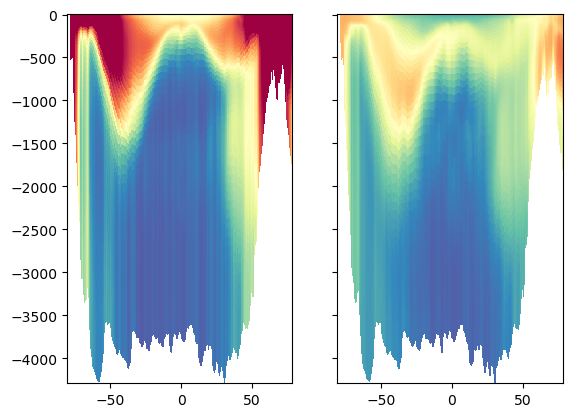

In [84]:
fig, ax = plt.subplots(1, 2, sharey = True)
import numpy.ma as ma

X = historical_zonal.z.values; X[np.isnan(X)] = 10

ax[0].pcolormesh(yh, Ym, 1e9 * Zm, shading = "gourad", cmap = "Spectral_r", vmin = 0, vmax = 2); 

X = ssp585_zonal.z.values; X[np.isnan(X)] = 10
Y = yh
Zm = ssp585_zonal.cfc12.values.T

ax[1].pcolormesh(yh, Ym, 1e9 * Zm, shading = "gourad", cmap = "Spectral_r", vmin = 0, vmax = 2); 

# ssp585_zonal.plot(ax = ax[0], add_colorbar = False)

# ax[0].invert_yaxis()